In [1]:
import tensorflow as tf 
import keras 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.compose import make_column_transformer

In [2]:
from sklearn.datasets import load_breast_cancer 

breast_cancer = load_breast_cancer() 
breast_cancer_df = pd.DataFrame(data=breast_cancer['data'], columns=breast_cancer['feature_names']) 
breast_cancer_df.isna().sum() 
breast_cancer_df['target'] = breast_cancer['target']

In [3]:
X = breast_cancer_df.drop('target', axis=1)
y = breast_cancer['target'] 
breast_cancer_df.target.value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [4]:
X.shape, breast_cancer_df.shape

((569, 30), (569, 31))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

columns = X_train.columns
col_transformer = make_column_transformer(
    (MinMaxScaler(), columns)
)


col_transformer.fit(X_train)
X_train_normal = col_transformer.transform(X_train)
X_test_normal = col_transformer.transform(X_test)

X_train_normal

array([[0.06552721, 0.25769361, 0.07732252, ..., 0.60137457, 0.52493594,
        0.52950153],
       [0.65620256, 0.57017247, 0.67420686, ..., 0.9975945 , 0.49931007,
        0.62190573],
       [0.07257946, 0.14034494, 0.08023901, ..., 0.174811  , 0.33845851,
        0.25313666],
       ...,
       [0.32317939, 0.2404464 , 0.30146536, ..., 0.11453608, 0.17602996,
        0.05222109],
       [0.30799745, 0.33513696, 0.30729834, ..., 0.62783505, 0.31815494,
        0.42777213],
       [0.21984426, 0.36557322, 0.20842225, ..., 0.25536082, 0.22255076,
        0.11648016]])

In [6]:
X_train_normal.shape

(455, 30)

In [14]:
# Model-1 

keras.utils.set_random_seed(42)

model_a = keras.Sequential([
    keras.layers.Dense(50, activation='relu', input_shape=(30,)), 
    keras.layers.Dense(1, activation='sigmoid')
])

model_a.compile(loss=keras.losses.BinaryCrossentropy(),
               optimizer=keras.optimizers.Adam(), 
               metrics=["accuracy", "recall"])

model_a.summary()

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
early_stopping = keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True,
                )

history_a = model_a.fit(X_train_normal,
                       y_train, 
                       epochs=100,  
                       callbacks=[lr_scheduler],
                       validation_data=(X_train_normal, y_train),  
                       verbose=0)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │         1,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,601 (6.25 KB)

 Trainable params: 1,601 (6.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_a_df = pd.DataFrame(history_a.history)
history_a_df[:3]

,accuracy,loss,recall,val_accuracy,val_loss,val_recall,learning_rate
0,0.501099,0.695796,0.318182,0.520879,0.693089,0.342657,0.000100
1,0.558242,0.691084,0.402098,0.584615,0.688401,0.461538,0.000112
2,0.613187,0.686247,0.513986,0.659341,0.683389,0.583916,0.000126


In [16]:
def plot_learning_rate_vs_loss(history):
    lrs = 1e-4 * (10 ** (tf.range(100) / 20))
    plt.figure(figsize=(10, 7))
    plt.semilogx(lrs, history.history['loss'])
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.title("Learning Rate vs Loss")

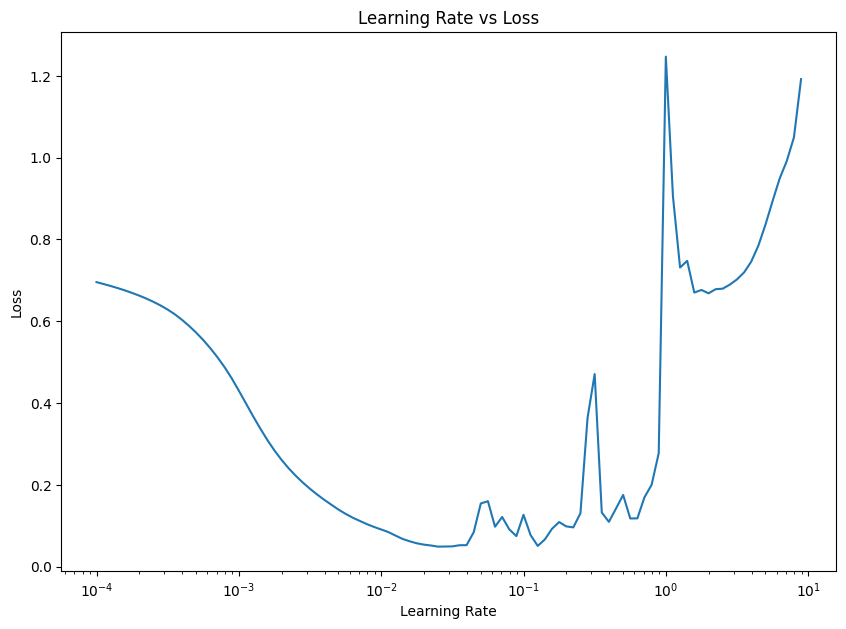

In [17]:
plot_learning_rate_vs_loss(history_a)

In [18]:
X_train.shape

(455, 30)

In [19]:
# model-b 

keras.utils.set_random_seed(42)

model_b = keras.Sequential(name='Model_B')
model_b.add(keras.layers.Dense(100, activation='relu', input_shape=(30,)))
model_b.add(keras.layers.Dense(100, activation='relu'))
model_b.add(keras.layers.Dense(1, activation='sigmoid'))

model_b.compile(
    loss=keras.losses.BinaryCrossentropy(), 
    optimizer=keras.optimizers.Adam(0.002),
    metrics=['accuracy']
)

model_b.summary()

Model: "Model_B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,301 (51.96 KB)

 Trainable params: 13,301 (51.96 KB)

 Non-trainable params: 0 (0.00 B)

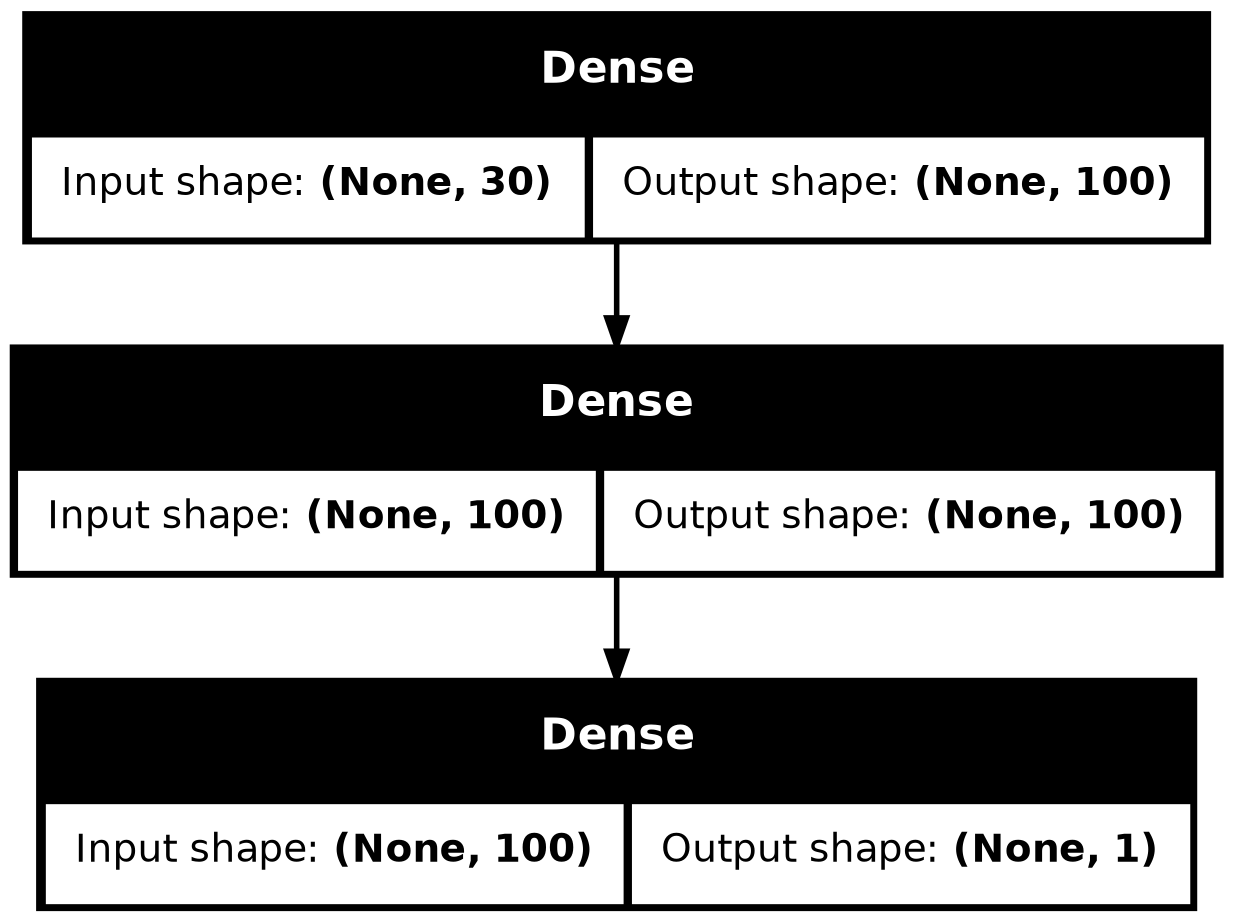

In [21]:
from keras.utils import plot_model

plot_model(model_b, show_shapes=True)

In [23]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    ), 
    keras.callbacks.ReduceLROnPlateau(
        monitor='vall_loss', 
        patience=5, 
        restore_best_weights=True
    )
]

history_b = model_b.fit(X_train_normal, 
                        y_train, 
                        validation_data=(X_test_normal, y_test), 
                        epochs=150, 
                        callbacks=callbacks, 
                        verbose=0
                       )

In [24]:
model_b.evaluate(X_test_normal, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9794 - loss: 0.0698 


[0.05613039806485176, 0.9824561476707458]

In [49]:
# model-b 

keras.utils.set_random_seed(42)

model_c = keras.Sequential(name='Model_C')
model_c.add(keras.layers.Dense(100, activation='relu', input_shape=(30,)))
model_c.add(keras.layers.Dense(100, activation='relu'))
model_c.add(keras.layers.Dense(100, activation='relu'))
model_c.add(keras.layers.Dense(1, activation='sigmoid'))

model_c.compile(
    loss=keras.losses.BinaryCrossentropy(), 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

history_c = model_c.fit(X_train, 
                        y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=150, 
                        callbacks=callbacks, 
                        verbose=1
                       )

Epoch 1/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5757 - loss: 8.1372 - val_accuracy: 0.9474 - val_loss: 0.1903 - learning_rate: 0.0010
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8930 - loss: 0.3400 - val_accuracy: 0.9474 - val_loss: 0.1317 - learning_rate: 0.0010
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8859 - loss: 0.4002 - val_accuracy: 0.9298 - val_loss: 0.1260 - learning_rate: 0.0010
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9066 - loss: 0.3785 - val_accuracy: 0.9474 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9067 - loss: 0.3045 - val_accuracy: 0.9561 - val_loss: 0.1117 - learning_rate: 0.0010


In [51]:
model_c.evaluate(X_test, y_test), model_b.evaluate(X_test_normal, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9352 - loss: 0.2138 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9794 - loss: 0.0698 


([0.19029299914836884, 0.9473684430122375],
 [0.05613039806485176, 0.9824561476707458])

<Axes: >

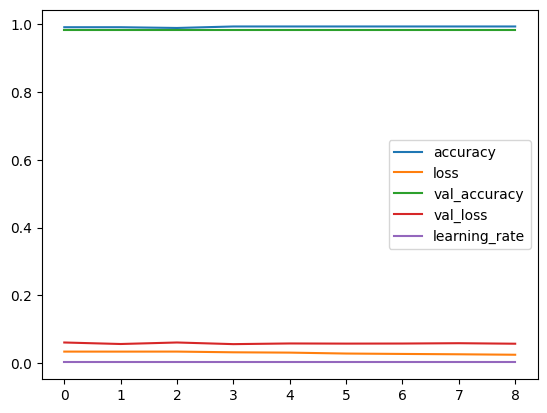

In [43]:
pd.DataFrame(history_b.history).plot()

<Axes: >

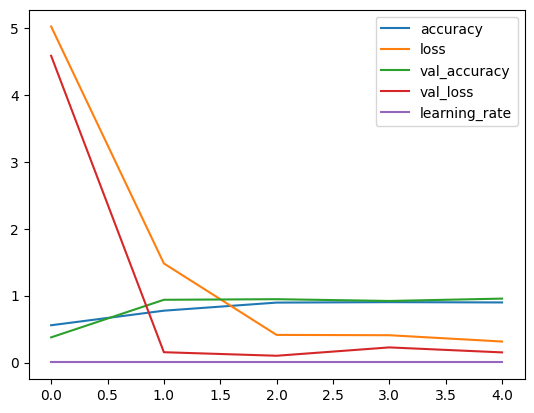

In [44]:
pd.DataFrame(history_c.history).plot()

In [53]:
y_preds_c = (model_c.predict(X_test) > 0.5).astype(int)
y_preds_c, y_test 
tf.squeeze(y_preds_c) == tf.squeeze(y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<tf.Tensor: shape=(114,), dtype=bool, numpy=
array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])>